![Movetru logo](../data/images/logo.webp)
# Gait event detection demo

This workbook contains a demo outlining a proof of concept for the gait event detection algorithm developed for the Movetru "Stage 2 Interview – Sports Biomechanics Data
Scientist Task". A complete brief is available in the parent directory as `brief.pdf`.

This notebook serves the purpose of explaining the algorithms and their implementation details, which are implemented in a more production-ready manner in the web app accompanying this work, which can be found [here](https://movetru-stride.streamlit.app/).

In this notebook, the user selects the IMU data to use (choosing the participant and trial), explores the data, and runs the detection algorithm on it. 

The sample data used throughout this work comes from the dataset provided by [Grouvel et al., 2023](https://www-nature-com.eux.idm.oclc.org/articles/s41597-023-02077-3). 

The event detection algorithms are inspired by the works of:
- [Falbriard et al., 2018](https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2018.00610/full)
- [Gouda and Andrysek, 2022](https://www.mdpi.com/1424-8220/22/22/8888)

## 1. Exploratory data analysis

Import the data for for a chosen participant, session and trial:

In [29]:
import polars as pl

# Participants available: P01-P10
participant = "P01"
# Sessions available: S01
session = "S01"
# Trials available: SlowGait, Gait, FastGait, Running
trial = "Gait"
# Trial IDs available: varies per trial. Here I use "01" as an example.
trial_id = "01"
# Sampling frequency (Hz)
fs = 100

# Load the data
sample_df = pl.read_csv(f"../data/synchronised/{participant}_{session}_{trial}_{trial_id}.csv")

We'll focus on the gyroscope data from the feet IMUs in the medial-lateral direction (which corresponds to the y-axis of the IMU), as this is the focus of the event detection algorithm. 

In [38]:
left_foot = sample_df["P6_LF_gyro_y"]
right_foot = sample_df["P6_RF_gyro_y"]

Plot the signals to visualize the data:

Text(0, 0.5, 'Ang. velocity (deg/s)')

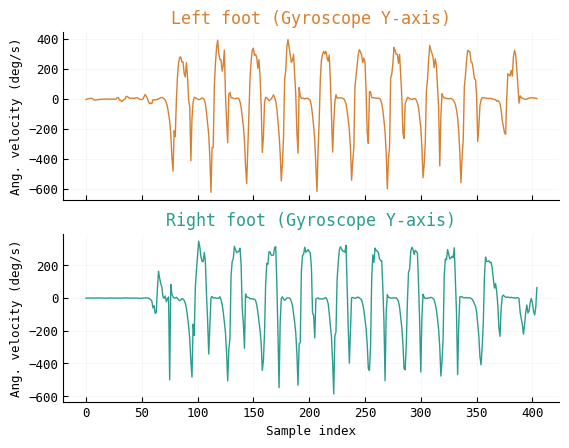

In [39]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("movetru.mplstyle")
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Calculate time values for the x-axis based on the sampling frequency
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(-left_foot, label="Left Foot Gyro Y", color=colours[0])
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
# ax[0].set_xlim([100, 200])
ax[1].plot(-right_foot, label="Right Foot Gyro Y", color=colours[1])
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")

## 2. Data cleaning

Although the data appears relatively clean and expectedly cyclic in nature, the event detection algorithm relies on the detection of local minima in the signal, which can be affected by high frequency noise.

Since we want the algorithm to also be near real-time any signal processing should be causal (i.e. not use future data points to clean the current point).

As such, we will use a simple moving average (SMA) filter to smooth the signal.

In [40]:
from helpers import moving_average
import numpy as np
from collections import deque

# Initialize state for both feet
feet_data = {
    'left': {'raw_signal': left_foot},
    'right': {'raw_signal': right_foot}
}

max_window_size = fs * 5  # Keep last 5 seconds of data in rolling window

for foot_name, foot_state in feet_data.items():
    foot_state['window'] = deque(maxlen=max_window_size)
    foot_state['all_smoothed'] = []

# Simulate receiving the data sample-by-sample
for i in range(len(left_foot)):
    for foot_name, foot_state in feet_data.items():
        # Add new sample to rolling window
        foot_state['window'].append(foot_state['raw_signal'][i])
        
        # Compute moving average on the rolling window
        smooth_value = moving_average(np.array(foot_state['window']), window=5)
        
        # Store smoothed value for plotting
        foot_state['all_smoothed'].append(smooth_value)

# Convert to numpy arrays for plotting
left_smoothed = np.array(feet_data['left']['all_smoothed'])
right_smoothed = np.array(feet_data['right']['all_smoothed'])

Visuaise the smoothed signals:

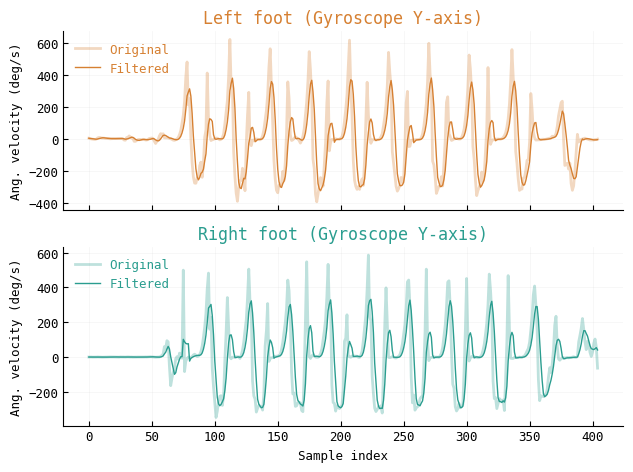

In [44]:
# Plot original and filtered signals
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_foot, label="Original", color=colours[0], alpha=0.3, linewidth=2)
ax[0].plot(left_smoothed, label=f"Filtered", color=colours[0], linewidth=1)
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left')

# Right foot
ax[1].plot(right_foot, label="Original", color=colours[1], alpha=0.3, linewidth=2)
ax[1].plot(right_smoothed, label=f"Filtered", color=colours[1], linewidth=1)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

## 3. Event detection

The filtered data now follows a clear trend: each local minima is followed by two local maxima.

From the typical healthy gait cycle, these minima correspond to the time between the foot off and foot contact events, also referred to as the mid-swing (MSW).

![Gait cycle](../data/images/typical_gait.png)

The local minima can therefore be used as an anchor from which to search to the left (for peaks corresponding to foot offs) and right (for zero-crossings corresponding to foot contacts).

### Real-time Mid-Swing Detection Algorithm

The algorithm works as follows:
1. **Track zero-crossings**: Monitor when the signal crosses zero (from positive to negative = descending ZC)
2. **After descending ZC**: Search for the first local minimum below a threshold
3. **Local minimum conditions**: 
   - Current value < previous value AND current value < next value
   - Current value < threshold (typically negative, e.g., < -100 deg/s)
   - Must occur after a descending zero-crossing

This approach is causal and suitable for real-time processing.

To tidy up the code here, I've implemented the functionality for zero crossings and detection of local minima into the `helpers` module.

In [34]:
from helpers import detect_zero_crossing_descending, detect_local_minimum

In [ ]:
# Real-time streaming simulation: smoothing + mid-swing detection
# Parameters
msw_threshold = -115  # deg/s (~ -2 rad/s)
zc_threshold = 0      # deg/s
ma_window = 5         # Moving average window size
max_buffer_size = fs * 5  # Keep last 5 seconds for smoothing

# Initialize state for both feet
feet_data = {
    'left': {'raw_signal': left_foot},
    'right': {'raw_signal': right_foot}
}

for foot_name, foot_state in feet_data.items():
    # Smoothing buffers
    foot_state['raw_buffer'] = deque(maxlen=max_buffer_size)
    foot_state['smoothed_history'] = []  # Store last 3 smoothed samples for min detection
    foot_state['all_smoothed'] = []  # Store ALL smoothed values for plotting
    
    # Event detection state
    foot_state['zc_prev'] = None
    foot_state['after_desc_zc'] = False
    foot_state['msw_indices'] = []
    foot_state['zc_desc_indices'] = []

# Simulate receiving RAW data sample-by-sample
for i in range(len(left_foot)):
    for foot_name, foot_state in feet_data.items():
        # STEP 1: Get new raw sample 
        raw_sample = foot_state['raw_signal'][i]
        
        # STEP 2: Update smoothing buffer 
        foot_state['raw_buffer'].append(raw_sample)
        
        # STEP 3: Compute smoothed value (moving average) 
        smoothed_sample = moving_average(np.array(foot_state['raw_buffer']), window=ma_window)
        foot_state['all_smoothed'].append(smoothed_sample)
        
        # STEP 4: Event Detection 
        # 1. Update history buffer for local minima detection (keep last 3 smoothed samples)
        foot_state['smoothed_history'].append(smoothed_sample)
        if len(foot_state['smoothed_history']) > 3:
            foot_state['smoothed_history'].pop(0)
        
        # 2. Detect zero-crossing
        foot_state['zc_prev'], is_desc_zc = detect_zero_crossing_descending(
            smoothed_sample, foot_state['zc_prev'], zc_threshold
        )
        
        if is_desc_zc:
            foot_state['after_desc_zc'] = True
            foot_state['zc_desc_indices'].append(i)
        
        # 3. Detect local minimum after descending zero-crossing
        if foot_state['after_desc_zc']:
            if detect_local_minimum(foot_state['smoothed_history'], msw_threshold):
                foot_state['msw_indices'].append(i - 1)  # The local min is at i-1
                foot_state['after_desc_zc'] = False  # Reset flag after detecting MSW

# Convert to numpy arrays for easier downstream processing
left_smoothed = np.array(feet_data['left']['all_smoothed'])
right_smoothed = np.array(feet_data['right']['all_smoothed'])
msw_left = np.array(feet_data['left']['msw_indices'])
msw_right = np.array(feet_data['right']['msw_indices'])
zc_left = np.array(feet_data['left']['zc_desc_indices'])
zc_right = np.array(feet_data['right']['zc_desc_indices'])

### Visualize detected mid-swing events

Let's visualize the detected events along with the zero-crossings to verify the algorithm is working correctly:

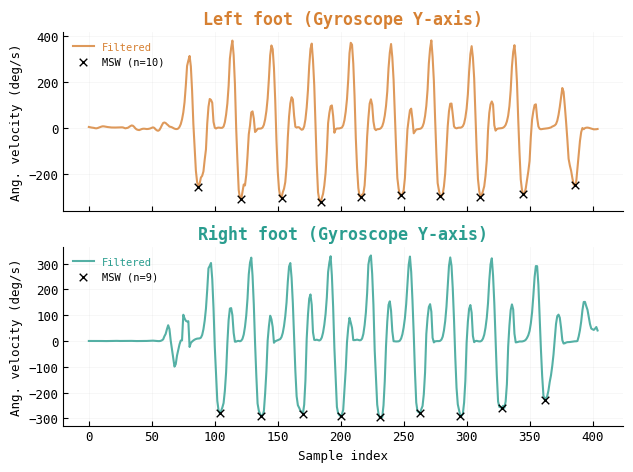

In [37]:
# Plot original signal with detected mid-swing events and zero-crossings
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_smoothed, label=f"Filtered", color=colours[0], linewidth=1.5, alpha=0.8)
ax[0].scatter(msw_left, left_smoothed[msw_left], color='black', s=30, zorder=5, 
             label=f'MSW (n={len(msw_left)})', marker='x', linewidths=1)
ax[0].set_title("Left foot (Gyroscope Y-axis)", fontweight='bold')
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left',fontsize='small')

# Right foot
ax[1].plot(right_smoothed, label=f"Filtered", color=colours[1], linewidth=1.5, alpha=0.8)
ax[1].scatter(msw_right, right_smoothed[msw_right], color='black', s=30, zorder=5, 
             label=f'MSW (n={len(msw_right)})', marker='x', linewidths=1)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1], fontweight='bold')
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left',fontsize='small')

plt.tight_layout()
plt.show()

### Foot strike (FS) and foot off (FO) detection

We can search between consecutively detected MSWs for the peaks corresponding to the FS and FOs. The algorithm for doing so is described in detail in [Falbriard et al., 2018](https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2018.00610/full), but in summary:
1. For each pair of consecutive MSWs, search for the minimum velocity norm between the two MSWs (this corresponds to the mid stance, where the foot is approximately stationary)
2. Between mid stance and previous mid swing, search backwards for the maximum (this corresponds to the foot off).
3. Between mid stance and next mid swing, search forwards for the maximum (this corresponds to the foot strike).


In [45]:
from helpers import process_gait_data_realtime

# Parameters
msw_threshold = -115  # deg/s (= -2 rad/s)
ma_window = 5         # Moving average window size
max_stride_time = 2.5  # seconds

print("Simulating complete real-time pipeline: raw data -> smoothing -> MSW detection -> FS/MS/FO detection")
print(f"Moving average window: {ma_window} samples")
print(f"MSW threshold: {msw_threshold} deg/s")
print(f"Max stride time: {max_stride_time}s")
print()

# Process both feet with the complete pipeline
results = process_gait_data_realtime(
    left_foot, 
    right_foot, 
    fs,
    msw_threshold=msw_threshold,
    ma_window=ma_window,
    max_stride_time=max_stride_time
)

# Extract results for easier access
left_smoothed = results['left']['smoothed']
right_smoothed = results['right']['smoothed']
msw_left = results['left']['msw_indices']
msw_right = results['right']['msw_indices']
ms_left = results['left']['mid_stance_indices']
ms_right = results['right']['mid_stance_indices']
fs_left = results['left']['foot_strike_indices']
fs_right = results['right']['foot_strike_indices']
fo_left = results['left']['foot_off_indices']
fo_right = results['right']['foot_off_indices']

# Display detection results
print(f"Processed {len(left_foot)} raw samples")
print(f"\nMid-swing detection results:")
print(f"  Left foot:  {len(msw_left)} mid-swings")
print(f"  Right foot: {len(msw_right)} mid-swings")
print(f"\nGait event detection results:")
print(f"  Left foot:  {len(fs_left)} foot strikes, {len(ms_left)} mid-stances, {len(fo_left)} foot offs")
print(f"  Right foot: {len(fs_right)} foot strikes, {len(ms_right)} mid-stances, {len(fo_right)} foot offs")

Simulating complete real-time pipeline: raw data -> smoothing -> MSW detection -> FS/MS/FO detection
Moving average window: 5 samples
MSW threshold: -115 deg/s
Max stride time: 2.5s

Processed 405 raw samples

Mid-swing detection results:
  Left foot:  10 mid-swings
  Right foot: 9 mid-swings

Gait event detection results:
  Left foot:  9 foot strikes, 9 mid-stances, 9 foot offs
  Right foot: 8 foot strikes, 8 mid-stances, 8 foot offs


Finally, visualise all of the detected events:

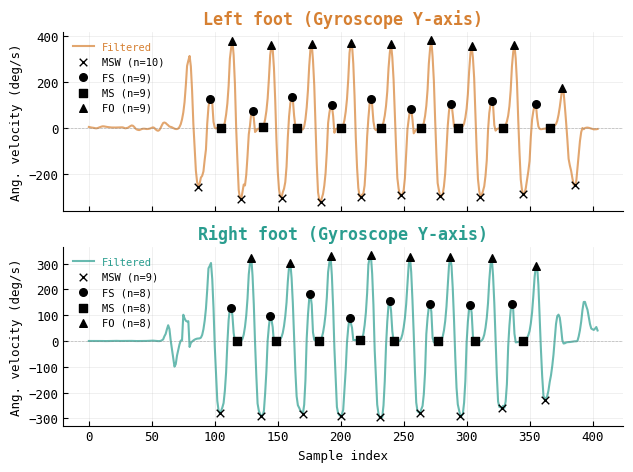

In [48]:
# Plot filtered signal with all detected gait events
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_smoothed, label="Filtered", color=colours[0], linewidth=1.5, alpha=0.7)
ax[0].scatter(msw_left, left_smoothed[msw_left], color='black', s=30, zorder=5, 
             label=f'MSW (n={len(msw_left)})', marker='x', linewidths=1)
ax[0].scatter(fs_left, left_smoothed[fs_left], color='black', s=30, zorder=5, 
             label=f'FS (n={len(fs_left)})', marker='o')
ax[0].scatter(ms_left, left_smoothed[ms_left], color='black', s=30, zorder=5, 
             label=f'MS (n={len(ms_left)})', marker='s')
ax[0].scatter(fo_left, left_smoothed[fo_left], color='black', s=30, zorder=5, 
             label=f'FO (n={len(fo_left)})', marker='^')
ax[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax[0].set_title("Left foot (Gyroscope Y-axis)", fontweight='bold')
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left',fontsize='small')
ax[0].grid(True, alpha=0.3)

# Right foot
ax[1].plot(right_smoothed, label="Filtered", color=colours[1], linewidth=1.5, alpha=0.7)
ax[1].scatter(msw_right, right_smoothed[msw_right], color='black', s=30, zorder=5, 
             label=f'MSW (n={len(msw_right)})', marker='x', linewidths=1)
ax[1].scatter(fs_right, right_smoothed[fs_right], color='black', s=30, zorder=5, 
             label=f'FS (n={len(fs_right)})', marker='o')
ax[1].scatter(ms_right, right_smoothed[ms_right], color='black', s=30, zorder=5, 
             label=f'MS (n={len(ms_right)})', marker='s')
ax[1].scatter(fo_right, right_smoothed[fo_right], color='black', s=30, zorder=5, 
             label=f'FO (n={len(fo_right)})', marker='^')
ax[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1], fontweight='bold')
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left',fontsize='small')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()